In [346]:
import os,sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import math

In [347]:
%matplotlib inline

In [210]:
matplotlib.get_configdir()

u'/home/prateeks/.config/matplotlib'

In [211]:
#plt.style.use('plt-paper-style')

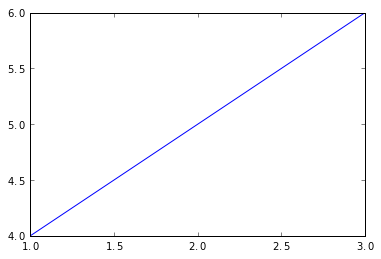

In [212]:
plt.plot([1,2,3],[4,5,6])

In [348]:
plt.show()

In [349]:
def Pfail(p,n):
    return 1.0-math.pow((1-p),n)

In [350]:
def ExpectedTime(T, MTTF, N):
    T = float(T)
    MTTF=float(MTTF)
    p = min(T/MTTF, 1.0)
    pf = Pfail(p, N)
    eT = T + ((T/2)*pf)
    return (eT, pf) 

In [351]:
ExpectedTime(12, 4, 2)

(18.0, 1.0)

In [410]:
par_speedup_1 = {1:1, 2:0.55, 4:0.3, 8:0.2, 16:0.15}
prices = {1:1, 2:2, 4:4, 8:8, 16:16,32:32,64:64} #Are always linear
preemptible_prices={ 2:0.0150,4: 0.0300, 8:0.0600,16:0.1200,32: 0.2400,64:0.4800 }
ondem_prices={2:0.0709,4:  0.1418, 8:  0.2836,16:  0.5672,32:  1.1344,64:  2.2688 }
#Keyed by server size
#mttfs = {1:14, 2:10, 4:10, 8:8, 16:7}
mttfs = {1:5, 2:5, 4:5, 8:5, 16:5, 32:4, 64:0.2}
 #Keyed by server size 

In [353]:
def SimuExpMemoryless(par_speedup, prices, mttfs):
    out = []
    for p in par_speedup.keys():
        T = par_speedup[p]
        eT, pfail = ExpectedTime(T, mttfs[p], p)
        recomputation = eT-T
        cost = eT*prices[p]
        out.append((p, eT, T, pfail, cost))
    
    times = out 
    x=zip(*times)[0]
    ets=zip(*times)[1]
    nofails=zip(*times)[2]
    pfails=zip(*times)[3]
    costs=zip(*times)[4]
    return (x, ets, nofails, pfails, costs)
    

In [354]:
(x, ets, nofails, pfails, costs) = SimuExpMemoryless(par_speedup_1, prices, mttfs)

In [355]:
def plot_all(par_speedup):
    (x, ets, nofails, pfails, costs) = SimuExpMemoryless(par_speedup, prices, mttfs)
    (fig1, ax) = plt.subplots(nrows=2, ncols=2)
    fig1.set_size_inches(10,8)
    ((ax1, ax2), (ax3, ax4)) = ax 
    ax1.scatter(x,ets,marker='x',label='Expected Time')
    ax1.scatter(x,nofails,color='r',label='Recomputation Time')
    ax1.set_ylim((0))
    ax1.grid()
    ax1.legend()
    
    #fig2, ax2 = plt.subplots(nrows=2, ncols=1)
    ax2.scatter(x,pfails,color='k',label='Failure Probability')
    ax2.legend()
    ax2.grid()
    
    #fig3, ax3 = plt.subplots()

    ax3.scatter(x, costs, label="Expected Cost")
    ax3.legend()
    ax3.grid()
    
    #fig4, ax4 = plt.subplots()
    ax4.scatter(x, np.array(costs)*np.array(ets), color='r', label="Cost/Speedup")
    ax4.legend()
    ax4.grid()

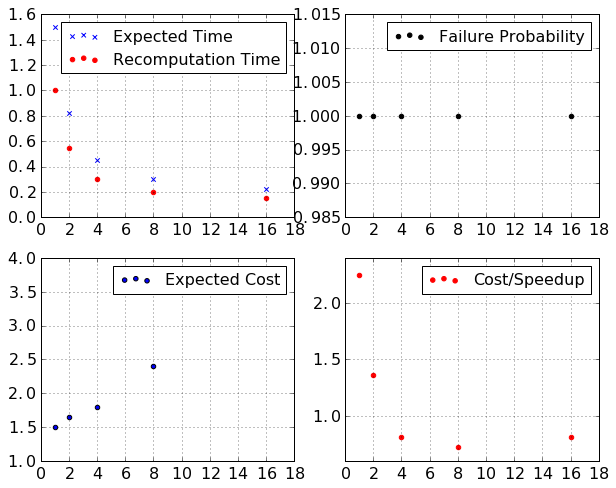

In [310]:
par_speedup_1 = {1:1, 2:0.55, 4:0.3, 8:0.2, 16:0.15}
plot_all(par_speedup_1)

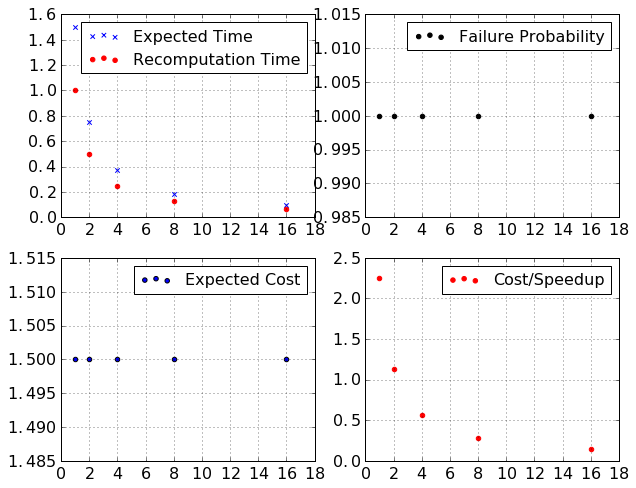

In [311]:
par_speedup_perfect = {1:1, 2:0.5, 4:0.25, 8:1.0/8, 16:1.0/16}
plot_all(par_speedup_perfect)

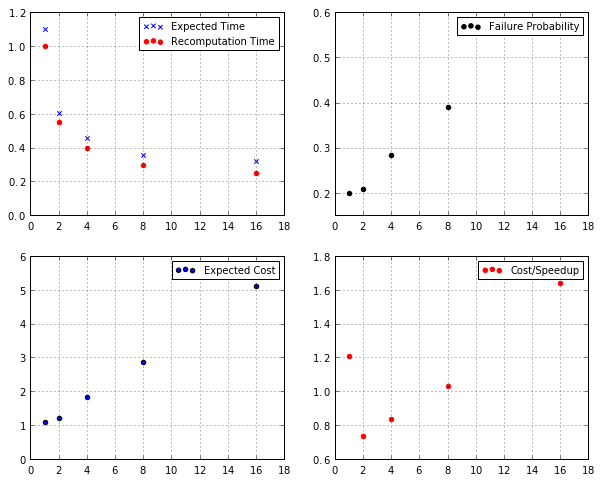

In [223]:
par_speedup_poor = {1:1, 2:0.55, 4:0.4, 8:0.3, 16:0.25}
plot_all(par_speedup_poor)

In [224]:
#confinement data

In [356]:
confinement_runtimes = {16:{16:30, 8:35, 4:37, 2:39}, 64:{64:11, 32:15, 16:15, 8:18, 4:21}}
#total_num_cpus:{server-cpus:run_time} 


In [455]:
lulesh_runtimes = {16:{16:30, 8:35, 4:37, 2:39}, 64:{64:12.7, 32:0, 16:0, 8:22.5, 4:0}}

In [358]:
shapes_runtimes = {16:{16:30, 8:35, 4:37, 2:39}, 64:{64:11, 32:9.6, 16:9, 8:9, 4:9}}


In [359]:
MPI tasks & VMs(CPUs) & Runtime (s) & Total Time (s) \\
1         & 64        & 762.22      & 776.64         \\
8         & 8         & 1370.63     & 3164.12       

9.6

In [454]:
762/60.0

12.7

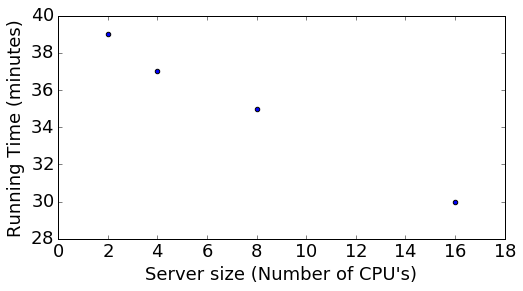

In [361]:
matplotlib.rcParams.update({'font.size': 18})
fig,ax=plt.subplots()
fig.set_size_inches(8,4)
runtimes = confinement_runtimes[16]
server_size = runtimes.keys()
r_minutes = runtimes.values()
ax.scatter(server_size, r_minutes)
ax.set_xlabel("Server size (Number of CPU's)")
ax.set_ylabel("Running Time (minutes)")
plt.savefig("../graphs/Confinement_explore_16.pdf",bbox_inches='tight')

In [362]:
def Exp_time_cost_memoryless(total_cpus, runtimes, prices, mttfs):
    #Assumes memoryless failures etc 
    out = []
    times = runtimes[total_cpus]
    
    for server_size in sorted(times.keys()):
        T = times[server_size]/60.0 
        num_servers = int(total_cpus/server_size) 
        eT, pfail = ExpectedTime(T, mttfs[server_size], num_servers)
        recomputation = eT-T
        cost = eT*prices[server_size]*num_servers
        ondem_cost = T*prices[server_size]*5*num_servers
        out.append((server_size, eT, T, pfail, cost, ondem_cost))
    
    times = out 
    all_outputs = list(zip(*times))
    x=all_outputs[0]
    ets=all_outputs[1]
    nofails=all_outputs[2]
    pfails=all_outputs[3]
    costs=all_outputs[4]
    ondem_costs=all_outputs[5]
    return (x, ets, nofails, pfails, costs, ondem_costs)

In [363]:
d={64:{64: 0.5}}
Exp_time_cost_memoryless(64,d, prices, mttfs)

((64,),
 (0.008506944444444444,),
 (0.008333333333333333,),
 (0.04166666666666663,),
 (0.5444444444444444,),
 (2.6666666666666665,))

In [364]:
def time_simuation_data():
    runt = [0.5, 1.5, 3, 6, 12]
    out = []
    for t in runt:
        d={64:{64: t}}
        (x, ets, nofails, pfails, costs, ondem_costs) = Exp_time_cost_memoryless(64, d, prices, mttfs)
        out.append()

In [365]:
all_runtime_dict = dict()
apps=['NC','Shapes']
runtimes=[confinement_runtimes, shapes_runtimes]
for (a, r) in zip(apps, runtimes):
    (x, ets, nofails, pfails, costs, ondem_costs) = Exp_time_cost_memoryless(64, r, prices, mttfs)
    all_runtime_dict[a] = (x, ets, nofails, pfails, costs, ondem_costs)

In [366]:
all_runtime_dict

{'NC': ((4, 8, 16, 32, 64),
  (0.4702019347010997,
   0.3585646592188378,
   0.27318671875,
   0.26513671875,
   0.26736111111111105),
  (0.35, 0.3, 0.25, 0.25, 0.18333333333333332),
  (0.6868681982919986,
   0.3904310614589187,
   0.18549375000000012,
   0.12109375,
   0.9166666666666665),
  (30.092923820870382,
   22.94813819000562,
   17.48395,
   16.96875,
   17.111111111111107),
  (112.0, 96.0, 80.0, 80.0, 58.666666666666664)),
 'Shapes': ((4, 8, 16, 32, 64),
  (0.17893097599029859,
   0.1662192480421728,
   0.15860303925,
   0.166272,
   0.26736111111111105),
  (0.15, 0.15, 0.15, 0.16, 0.18333333333333332),
  (0.38574634653731454,
   0.2162566405623041,
   0.11470719000000007,
   0.07840000000000003,
   0.9166666666666665),
  (11.45158246337911,
   10.63803187469906,
   10.150594512,
   10.641408,
   17.111111111111107),
  (48.0, 48.0, 48.0, 51.2, 58.666666666666664))}

In [367]:
def plot_bars(all_runtime_dict):
    matplotlib.rcParams.update({'font.size': 16})
    fig,ax=plt.subplots()
    fig.set_size_inches(8,5)
    w=0.2
    g=w
    #TODO: get the brc4 colors here!
    colors=['#edf8b1', '#7fcdbb', '#2c7fb8', 'black'] #Sequential
    first_recomp=True
    for i,a in enumerate(all_runtime_dict.keys()):
        
        X=list(all_runtime_dict[a][0])
        ets=all_runtime_dict[a][1]
        nofails=all_runtime_dict[a][2]
        pfails=all_runtime_dict[a][3]
        costs=all_runtime_dict[a][4]
        ondem_costs=all_runtime_dict[a][5]
        recomputation_time = np.array(ets)-np.array(nofails)
        barlocs = np.arange(len(X))+(w*i)+g
        print(barlocs)
        ax.bar(barlocs, nofails, color=colors[i],lw=0.3, width=w, label=a)
        if first_recomp is True:
            ax.bar(barlocs, recomputation_time, bottom=nofails,  color='k',lw=0.3,width=w,label='Recomputation')
            first_recomp = False
        else:
            ax.bar(barlocs, recomputation_time, bottom=nofails,  color='k',lw=0.3,width=w)

    
    
    
    ax.set_xlabel("VM Size (#CPUs). Total #CPUs=64")
    ax.set_ylabel("Running Time (hours)")
    ax.set_xticks(np.arange(len(X))+w)
    ax.set_xticklabels(X)
    ax.set_xlim((-0.1))
    ax.legend()
    plt.savefig("../graphs/runtime-bars.pdf",bbox_inches='tight')

[ 0.2  1.2  2.2  3.2  4.2]
[ 0.4  1.4  2.4  3.4  4.4]


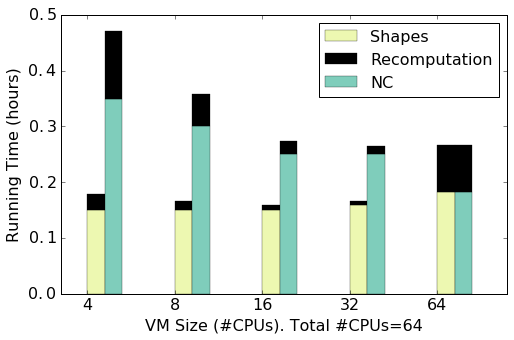

In [368]:
plot_bars(all_runtime_dict)

In [437]:
best_server_idx = 3 #Assume 32 is best for now always. TOFIX
median_server_idx = 1
def get_cost_comparison_data(all_runtime_dict, wkload, best_server_idx, median_server_idx):
    best_server = all_runtime_dict[wkload][0][best_server_idx]
    median_server = all_runtime_dict[wkload][0][median_server_idx]
    print("Best server is", best_server)

    scispot_cost = []
    ondem_ss = []
    ondem_median = []
    
    a=wkload
    ets=all_runtime_dict[a][1]
    nofails=all_runtime_dict[a][2]
    pfails=all_runtime_dict[a][3]
    costs=all_runtime_dict[a][4]
    ondem_costs=all_runtime_dict[a][5]
    recomputation_time = np.array(ets)-np.array(nofails)

    eT = ets[best_server_idx]
    Tbest = nofails[best_server_idx]
    num_servers_best = 64/best_server 
    num_servers_median = 64/median_server 
    
    Tmedian = nofails[median_server_idx]
    #print(Tbest, Tmedian)
    scispot_cost = preemptible_prices[best_server]*eT*num_servers_best
    ondem_ss = ondem_prices[best_server]*Tbest*num_servers_best
    ondem_median = ondem_prices[median_server]*Tmedian*num_servers_median
    
    return (scispot_cost, ondem_ss, ondem_median)
    

In [438]:
nc_costs = get_cost_comparison_data(all_runtime_dict, "NC", 3, 1)
print nc_costs

('Best server is', 32)
(0.127265625, 0.5672, 0.68064)


In [443]:
shapes_cost = get_cost_comparison_data(all_runtime_dict, "Shapes", 3, 1)
print shapes_cost

('Best server is', 32)
(0.07981056, 0.36300800000000005, 0.34032)


In [430]:
zip(nc_costs, shapes_cost)

[(0.127265625, 0.07981056), (0.5672, 0.36300800000000005), (0.68064, 0.34032)]

In [431]:
#all_runtime_dict

In [432]:
all_runtime_dict['NC'][4][0]

30.092923820870382

In [433]:
get_cost_comparison_data(all_runtime_dict)

TypeError: get_cost_comparison_data() takes exactly 4 arguments (1 given)

In [450]:
def plot_costs(all_runtime_dict):
    matplotlib.rcParams.update({'font.size': 16})
    fig,ax=plt.subplots()
    fig.set_size_inches(8,4)
    w=0.05
    g=w
    colors=['#edf8b1', '#7fcdbb', '#2c7fb8', 'black']
    nc_costs = get_cost_comparison_data(all_runtime_dict, "NC", 3, 1)
    shapes_cost = get_cost_comparison_data(all_runtime_dict, "Shapes", 3, 1)
    scispot_cost, ondem_ss, ondem_median = zip(nc_costs, shapes_cost)
    print (scispot_cost, ondem_ss, ondem_median)
    apps = ["NC", "Shapes"]
    X = np.arange(len(apps))
    #for (i, a) in enumerate(apps):
    barlocs = np.array(X + (1*w*1) + g) 
    ax.bar(barlocs, scispot_cost, width=w, color='k', label='SciSpot')
    ax.bar(barlocs+w+g, ondem_ss, width=w, color=colors[0],label='On-demand with server selection' )
    ax.bar(barlocs+2*(w+g), ondem_median, width=w, color=colors[1], label='On-demand on median server')
    ax.legend(bbox_to_anchor=(1.1,1.3))
    ax.set_xlabel("Application")
    ax.set_xticks(X+4*w)
    ax.set_xticklabels(apps)
    ax.set_ylabel("Cost per job ($)")
    plt.savefig("../graphs/cost-only-bar.pdf",bbox_inches='tight')

('Best server is', 32)
('Best server is', 32)
((0.127265625, 0.07981056), (0.5672, 0.36300800000000005), (0.68064, 0.34032))


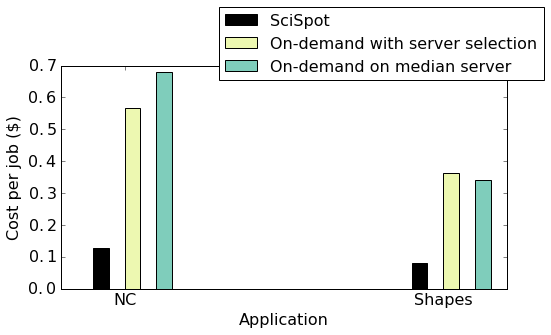

In [451]:
plot_costs(all_runtime_dict)

HPC vs SciSpot comparison


HPC waiting times from the hopc-job-wait-time notebook

In [374]:
hpc_waits=[1.8582890039463813,
 2.4206398187707769,
 1.5666587797773814,
 0.72541435731731119,
 0.32613828224381136]

In [375]:
#Get the recomputation/job times for these job lengths
jtimes = [0.5, 1.5, 3, 6, 12]
#eT, pfail = ExpectedTime(T, mttfs[server_size], num_servers)
server_size=32
num_servers=2
scispot_overhead=[]
for T in jtimes:
    eT, pfail = ExpectedTime(T, mttfs[server_size], num_servers)
    scispot_overhead.append((eT-T)/float(T))

In [376]:
scispot_overhead

[0.1171875, 0.3046875, 0.46875, 0.5, 0.5]

In [377]:
eT, pfail = ExpectedTime(12, 4, 2)
print(eT, pfail)

(18.0, 1.0)


In [395]:
def plot_wait_times():
    matplotlib.rcParams.update({'font.size': 16})
    fig,ax=plt.subplots()
    fig.set_size_inches(8,5)
    w=0.2
    g=w
    colors=['#edf8b1', '#7fcdbb', '#2c7fb8', 'black']
    X = np.array([0,1,2,3,4])
    ax.bar(X+w, np.array(hpc_waits)*100, width=w, color=colors[0], label='HPC Cluster')
    ax.bar(X+2*w, np.array(scispot_overhead)*100, width=w, color='k', label='SciSpot')
    ax.set_xticklabels(["<1","1--2", "2--4", "4--8", "8--16"])
    ax.set_xticks(X+2*w)
    ax.legend(loc='best')
    ax.set_xlabel("Job Running Time (hours)")
    ax.set_ylabel("Average % Increase in Running Time")
    plt.savefig("../graphs/hpc-vs-scispot.pdf",bbox_inches='tight')

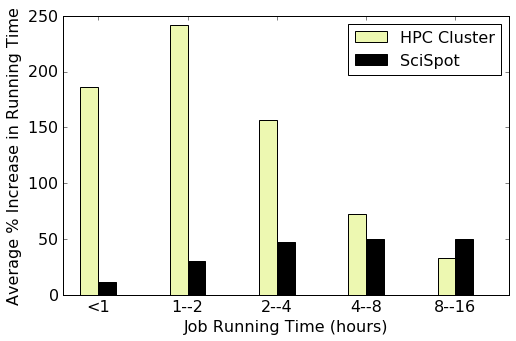

In [396]:
plot_wait_times()

In [103]:
def plot_run_cost(num_cpus, wkload, runtime_data, prices, mttfs):
    (x, ets, nofails, pfails, costs, ondem_costs) = Exp_time_cost_memoryless(num_cpus, runtime_data, prices, mttfs)
    
    matplotlib.rcParams.update({'font.size': 16})
    fig,ax=plt.subplots()
    fig.set_size_inches(8,4)
    ax.scatter(x, ets, label="Preemptible")
    ax.scatter(x, nofails, label="On-demand", color='r',marker='x')
    ax.set_xlabel("Server Size (Total number of CPUs={})".format(num_cpus))
    ax.set_ylabel("Running Time (Hours)")
    ax.legend(fontsize='small')
    fname = "../graphs/{}_{}_time.pdf".format(wkload, num_cpus)
    plt.savefig(fname, bbox_inches="tight")
    
    fig,ax=plt.subplots()
    fig.set_size_inches(8,4)
    ax.scatter(x, costs, label="Preemptible")
    ax.scatter(x, ondem_costs, label="On-demand", color='r',marker='x')
    ax.set_xlabel("Server Size (Total number of CPUs={})".format(num_cpus))
    ax.set_ylabel("Expected Cost per Job")
    ax.legend(fontsize='small')
    fname="../graphs/{}_{}_cost.pdf".format(wkload, num_cpus)
    plt.savefig(fname, bbox_inches="tight")


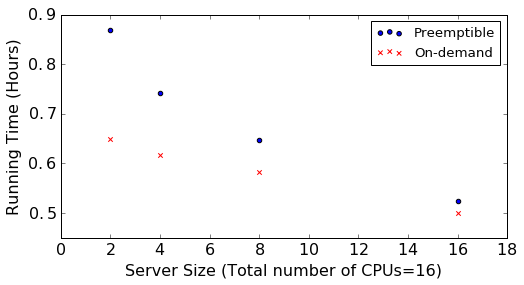

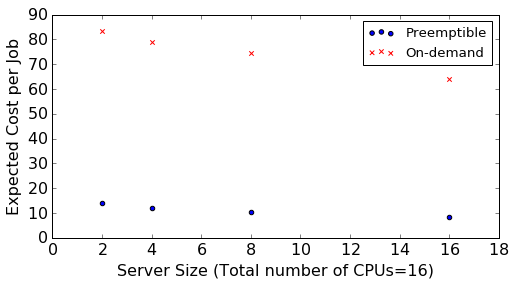

In [104]:
plot_run_cost(16, "confin", confinement_runtimes, prices, mttfs)

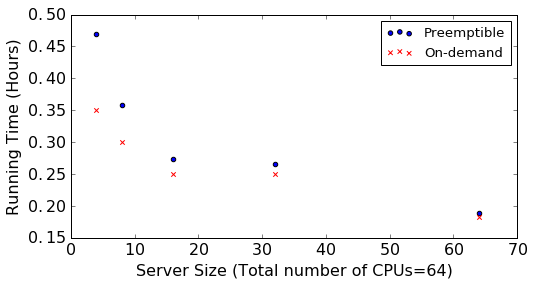

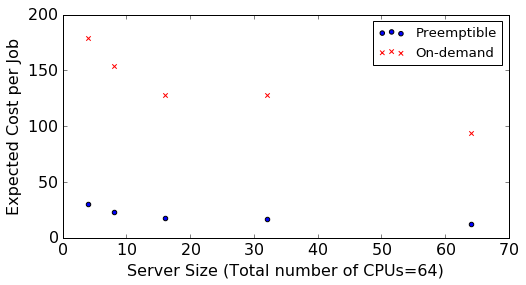

In [105]:
plot_run_cost(64, "confin", confinement_runtimes, prices, mttfs)